# Session 2.4: BakeryAI - Multi-Agent Systems

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1H_gkd8OkBHUjgLdWzhcsdi5AzkEK5dpa?usp=sharing)

## 🎯 Building a Multi-Agent Bakery System

Real businesses have multiple departments working together. Let's model that!

### Our Multi-Agent Architecture:

```
📊 Architecture:
              [Supervisor]
                   |
      _____________|______________
     |              |             |
[Customer Service] [Inventory] [Kitchen]
     |              |             |
      \_____________|_____________/
                   |
              [Supervisor]
                   |
                [FINISH]
```

### Why Multi-Agent?

**Single Agent** problems:
- ❌ One agent tries to do everything
- ❌ Hard to maintain and debug
- ❌ No specialization
- ❌ Can't scale

**Multi-Agent** benefits:
- ✅ Specialized expertise per agent
- ✅ Parallel processing
- ✅ Easier to maintain
- ✅ Better error isolation
- ✅ Realistic business modeling

### How It Works:

1. **Supervisor** receives customer request
2. **Supervisor** decides which agent(s) to call
3. Specialized agents do their work using tools
4. Agents report back to **Supervisor**
5. **Supervisor** coordinates final response

Let's build it! 🚀

In [1]:
!pip install -q langgraph langchain langchain-openai
!pip install -q pandas python-dotenv

!git clone https://github.com/IvanReznikov/mdx-langchain-conclave

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.0/76.0 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.6/207.6 kB 9.2 MB/s eta 0:00:00
Cloning into 'mdx-langchain-conclave'...
remote: Enumerating objects: 27, done.
remote: Counting objects: 100% (27/27), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 27 (delta 6), reused 24 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (27/27), 240.64 KiB | 13.37 MiB/s, done.
Resolving deltas: 100% (6/6), done.


In [ ]:
import os
from google.colab import userdata

# Set OpenAI API key from Google Colab's user environment or default
def set_openai_api_key(default_key: str = "YOUR_API_KEY") -> None:
    """Set the OpenAI API key from Google Colab's user environment or use a default value."""
    #if not (userdata.get("OPENAI_API_KEY") or "OPENAI_API_KEY" in os.environ):
    try:
      os.environ["OPENAI_API_KEY"] = userdata.get("MDX_OPENAI_API_KEY")
    except:
      os.environ["OPENAI_API_KEY"] = default_key

set_openai_api_key()
#set_openai_api_key("sk-...")

In [3]:
import os
import pandas as pd
import random
import functools
import operator
from datetime import datetime, timedelta
from typing import TypedDict, Annotated, Sequence, Literal
from dotenv import load_dotenv

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage, AIMessage, BaseMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import StateGraph, END
from langgraph.prebuilt import create_react_agent

llm = ChatOpenAI(model="gpt-4o", temperature=0)

In [4]:
# Load bakery data
try:
    cakes_df = pd.read_csv('/content/mdx-langchain-conclave/data/cake_descriptions.csv', encoding='cp1252')
    customers_df = pd.read_csv('/content/mdx-langchain-conclave/data/customers.csv', encoding='cp1252')
    orders_df = pd.read_csv('/content/mdx-langchain-conclave/data/orders.csv', encoding='cp1252')
    prices_df = pd.read_csv('/content/mdx-langchain-conclave/data/price_list.csv', encoding='utf-16')
    print(f"✅ Loaded: {len(cakes_df)} products, {len(customers_df)} customers, {len(orders_df)} orders")
except FileNotFoundError:
    cakes_df = pd.DataFrame({
        'Name': ['Chocolate Truffle Cake', 'Vanilla Bean Cake', 'Red Velvet Cake'],
        'Category': ['Chocolate', 'Vanilla', 'Specialty'],
        'Available': [True, True, True],
        'Weight_grams': [1000, 1000, 1200],
        'Delivery_time_hr': [24, 24, 48]
    })
    customers_df = pd.DataFrame({
        'client_id': ['C001', 'C002'],
        'client_name': ['Alice Johnson', 'Bob Smith'],
        'email': ['alice@example.com', 'bob@example.com'],
        'loyalty_points': [100, 50]
    })
    orders_df = pd.DataFrame({'order_id': ['O001'], 'status': ['delivered']})
    prices_df = pd.DataFrame({'Item': ['Chocolate Cake'], 'Unit_Price_AED': [45]})
    print("⚠️ Using sample data")

✅ Loaded: 22 products, 50 customers, 100 orders


## 1. Import Tools from Previous Notebooks

Each agent will have access to domain-specific tools.

In [5]:
# Customer Service Tools
@tool
def lookup_customer(query: str) -> str:
    """Look up customer information by name, email, or ID.
    Use this when you need to find customer details.

    Args:
        query: Customer identifier (name, email, or ID)

    Returns:
        Customer information as formatted string
    """
    query_lower = query.lower()

    if 'client_id' in customers_df.columns:
        customer = customers_df[customers_df['client_id'].str.lower() == query_lower]
    else:
        customer = pd.DataFrame()

    if customer.empty and 'client_name' in customers_df.columns:
        customer = customers_df[customers_df['client_name'].str.lower().str.contains(query_lower, na=False)]

    if customer.empty:
        return f"❌ Customer '{query}' not found in database."

    cust = customer.iloc[0]
    result = f"""✅ Customer Found:
- ID: {cust.get('client_id', 'N/A')}
- Name: {cust.get('client_name', 'N/A')}
- Email: {cust.get('email', 'N/A')}
- Loyalty Points: {cust.get('loyalty_points', 0)}"""

    return result

@tool
def track_order(order_id: str) -> str:
    """Track the status of an existing order.

    Args:
        order_id: The order ID to track

    Returns:
        Order status information
    """
    order = orders_df[orders_df['order_id'] == order_id]
    if order.empty:
        return f"❌ Order {order_id} not found."

    status = order.iloc[0].get('status', 'unknown')
    return f"✅ Order {order_id} status: {status}"

customer_service_tools = [lookup_customer, track_order]
print(f"✅ Customer Service tools: {[t.name for t in customer_service_tools]}")

✅ Customer Service tools: ['lookup_customer', 'track_order']


In [6]:
# Inventory Tools
@tool
def check_product_availability(product_name: str) -> str:
    """Check if a product is available in inventory.
    Use this to verify stock levels before confirming orders.

    Args:
        product_name: Name of the cake or product to check

    Returns:
        Availability status and details
    """
    product = cakes_df[cakes_df['Name'].str.contains(product_name, case=False, na=False)]

    if product.empty:
        return f"❌ Product '{product_name}' not found in our catalog."

    product_info = product.iloc[0]
    if product_info['Available']:
        return f"""✅ {product_info['Name']} is IN STOCK
- Delivery time: {product_info['Delivery_time_hr']} hours
- Category: {product_info['Category']}
- Weight: {product_info['Weight_grams']}g"""
    else:
        return f"❌ {product_info['Name']} is OUT OF STOCK"

@tool
def calculate_order_total(product_name: str, quantity: int = 1) -> str:
    """Calculate the total cost including delivery fee.
    Use this to provide pricing information to customers.

    Args:
        product_name: Name of the product
        quantity: Number of items (default: 1)

    Returns:
        Total cost breakdown
    """
    try:
        filtered = prices_df[prices_df['Item'].str.lower().str.contains(product_name.lower(), na=False)]
        price = filtered['Unit_Price_AED'].iloc[0]
    except:
        price = 45  # default

    subtotal = price * quantity
    delivery_fee = 10 if subtotal < 100 else 0
    total = subtotal + delivery_fee

    return f"""💰 Order Total:
- Product: {product_name} x {quantity}
- Subtotal: {subtotal} AED
- Delivery Fee: {delivery_fee} AED
- TOTAL: {total} AED"""

@tool
def update_inventory_levels(product_name: str, quantity_change: int) -> str:
    """Update inventory levels (increase or decrease stock).
    Use negative numbers to decrease stock, positive to add stock.

    Args:
        product_name: Product to update
        quantity_change: Amount to change (+/- units)

    Returns:
        Confirmation of update
    """
    action = "decreased" if quantity_change < 0 else "increased"
    return f"✅ Inventory {action} for {product_name} by {abs(quantity_change)} units"

inventory_tools = [check_product_availability, calculate_order_total, update_inventory_levels]
print(f"✅ Inventory tools: {[t.name for t in inventory_tools]}")

✅ Inventory tools: ['check_product_availability', 'calculate_order_total', 'update_inventory_levels']


In [7]:
# Kitchen Tools
@tool
def schedule_production(product_name: str, quantity: int, delivery_date: str) -> str:
    """Schedule production in the kitchen.
    Use this to add items to the production queue.

    Args:
        product_name: Product to produce
        quantity: Number of items
        delivery_date: Target delivery date

    Returns:
        Production schedule confirmation
    """
    # Simulate checking kitchen capacity
    can_produce = random.random() < 0.9  # 90% success rate

    if can_produce:
        production_time = datetime.now() + timedelta(hours=12)
        return f"""✅ Production SCHEDULED:
- Product: {product_name} x {quantity}
- Start Time: {production_time.strftime('%Y-%m-%d %H:%M')}
- Ready for delivery: {delivery_date}
- Assigned to: Chef Station #2"""
    else:
        return f"❌ Kitchen at FULL CAPACITY. Cannot schedule production for {delivery_date}."

@tool
def quality_check(product_name: str) -> str:
    """Perform quality control check on a product.

    Args:
        product_name: Product to check

    Returns:
        Quality check results
    """
    # Simulate quality check (95% pass rate)
    passed = random.random() < 0.95

    if passed:
        return f"✅ Quality Check PASSED for {product_name}. Ready for delivery."
    else:
        return f"⚠️ Quality Check FAILED for {product_name}. Remaking product."

kitchen_tools = [schedule_production, quality_check]
print(f"✅ Kitchen tools: {[t.name for t in kitchen_tools]}")

✅ Kitchen tools: ['schedule_production', 'quality_check']


## 2. Define Multi-Agent State

The state tracks messages and routing decisions.

In [8]:
class AgentState(TypedDict):
    """State for multi-agent system with supervisor pattern"""
    # Messages accumulate across agents
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # Next agent to call (controlled by supervisor)
    next: str

print("✅ Multi-agent state defined")
print("   - messages: Conversation history")
print("   - next: Routing decision from supervisor")

✅ Multi-agent state defined
   - messages: Conversation history
   - next: Routing decision from supervisor


## 3. Create Specialized Agent Nodes

Each agent is a ReAct agent with domain-specific tools.

In [9]:
# Create system prompts for each agent
customer_service_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are the Customer Service agent. Your role is to:\n"
            "- Look up customer information\n"
            "- Track orders\n"
            "- Handle customer inquiries\n"
            "Be friendly and helpful. Use the tools available to you.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

inventory_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are the Inventory agent. Your role is to:\n"
            "- Check product availability\n"
            "- Calculate pricing and totals\n"
            "- Update stock levels\n"
            "Provide accurate inventory information. Use the tools available to you.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

kitchen_prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            "You are the Kitchen agent. Your role is to:\n"
            "- Schedule production\n"
            "- Perform quality checks\n"
            "- Manage production capacity\n"
            "Ensure quality and timely production. Use the tools available to you.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

# Create agents with prompts
customer_service_agent = create_react_agent(
    llm,
    tools=customer_service_tools,
    prompt=customer_service_prompt
)

inventory_agent = create_react_agent(
    llm,
    tools=inventory_tools,
    prompt=inventory_prompt
)

kitchen_agent = create_react_agent(
    llm,
    tools=kitchen_tools,
    prompt=kitchen_prompt
)

# Create node wrapper functions
def customer_service_node(state: AgentState) -> AgentState:
    """Customer Service Agent Node"""
    print("\n👔 CUSTOMER SERVICE AGENT working...")
    result = customer_service_agent.invoke(state)
    return {"messages": result["messages"]}

def inventory_node(state: AgentState) -> AgentState:
    """Inventory Agent Node"""
    print("\n📦 INVENTORY AGENT working...")
    result = inventory_agent.invoke(state)
    return {"messages": result["messages"]}

def kitchen_node(state: AgentState) -> AgentState:
    """Kitchen Agent Node"""
    print("\n👨‍🍳 KITCHEN AGENT working...")
    result = kitchen_agent.invoke(state)
    return {"messages": result["messages"]}

print("\n✅ All specialized agents created!")
print("   - Customer Service: lookup_customer, track_order")
print("   - Inventory: check_product_availability, calculate_order_total, update_inventory_levels")
print("   - Kitchen: schedule_production, quality_check")


✅ All specialized agents created!
   - Customer Service: lookup_customer, track_order
   - Inventory: check_product_availability, calculate_order_total, update_inventory_levels
   - Kitchen: schedule_production, quality_check


/tmp/ipython-input-3666517705.py:45: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  customer_service_agent = create_react_agent(
/tmp/ipython-input-3666517705.py:51: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  inventory_agent = create_react_agent(
/tmp/ipython-input-3666517705.py:57: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  kitchen_agent = create_react_agent(


## 4. Create the Supervisor Agent

The supervisor coordinates which agent should act next.

In [10]:
# Define available agents
agents = ["customer_service", "inventory", "kitchen"]
options = ["FINISH"] + agents

# Supervisor prompt
system_prompt = (
    "You are the Supervisor managing a bakery with three specialized agents:\n\n"
    "1. **customer_service**: Handles customer lookups, order tracking, and inquiries\n"
    "2. **inventory**: Checks stock, calculates pricing, manages inventory levels\n"
    "3. **kitchen**: Schedules production, performs quality checks\n\n"
    "Your job is to route tasks to the appropriate agent based on the customer request.\n\n"
    "Do not assign the same agent more than 2 times in a row \n"
    "Given the conversation, decide which agent should act next.\n"
    "When the task is complete, respond with FINISH.\n\n"
    "**Routing Guidelines:**\n"
    "- Customer info/tracking → customer_service\n"
    "- Stock/pricing questions → inventory\n"
    "- Production/quality → kitchen\n"
    "- For orders: customer_service → inventory → kitchen → FINISH\n"
)

# Create supervisor prompt template
supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            f"Select one of: {options}",
        ),
    ]
).partial(options=str(options), agents=", ".join(agents))

print("✅ Supervisor prompt created")
print(f"   Available agents: {agents}")
print(f"   Options: {options}")

✅ Supervisor prompt created
   Available agents: ['customer_service', 'inventory', 'kitchen']
   Options: ['FINISH', 'customer_service', 'inventory', 'kitchen']


In [11]:
# Supervisor decision function
def supervisor_node(state: AgentState) -> AgentState:
    """Supervisor decides which agent acts next"""
    print("\n🎯 SUPERVISOR making routing decision...")

    # Use LLM with structured output
    class RouteResponse(TypedDict):
        """Route to next agent"""
        next: Literal["customer_service", "inventory", "kitchen", "FINISH"]

    supervisor_chain = supervisor_prompt | llm.with_structured_output(RouteResponse)
    result = supervisor_chain.invoke(state)

    next_agent = result["next"]
    print(f"   → Routing to: {next_agent}")

    return {"next": next_agent}

print("✅ Supervisor node created")

✅ Supervisor node created


## 5. Build the Multi-Agent Graph

Supervisor routes to agents, agents report back to supervisor.

In [12]:
# Create the graph
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("supervisor", supervisor_node)
workflow.add_node("customer_service", customer_service_node)
workflow.add_node("inventory", inventory_node)
workflow.add_node("kitchen", kitchen_node)

# Supervisor is the entry point
workflow.set_entry_point("supervisor")

# Each agent reports back to supervisor
for agent in agents:
    workflow.add_edge(agent, "supervisor")

# Supervisor routes to agents or finishes
def should_continue(state: AgentState) -> str:
    """Check if we should continue or finish"""
    if state["next"] == "FINISH":
        return "end"
    return state["next"]

workflow.add_conditional_edges(
    "supervisor",
    should_continue,
    {
        "customer_service": "customer_service",
        "inventory": "inventory",
        "kitchen": "kitchen",
        "end": END,
    },
)

# Compile the graph
multi_agent_app = workflow.compile()

## 6. Test the Multi-Agent System

In [13]:
# Test 1: Simple customer lookup
print("=" * 70)
print("🧪 TEST 1: Customer Lookup")
print("=" * 70)

initial_state = {
    "messages": [
        HumanMessage(content="Can you look up Robert Johnson?")
    ],
}

result = multi_agent_app.invoke(initial_state)

print("\n✅ FINAL RESPONSE:")
print(result["messages"][-1].content)

🧪 TEST 1: Customer Lookup

🎯 SUPERVISOR making routing decision...
   → Routing to: customer_service

👔 CUSTOMER SERVICE AGENT working...

🎯 SUPERVISOR making routing decision...
   → Routing to: FINISH

✅ FINAL RESPONSE:
I found the information for Robert Johnson:

- **Customer ID:** C027
- **Name:** Robert Johnson
- **Email:** robert.johnson@email.com
- **Loyalty Points:** 232

Is there anything else I can assist you with today?


In [14]:
# Test 2: Complete order workflow
print("\n" + "=" * 70)
print("🧪 TEST 2: Complete Order Workflow")
print("=" * 70)

order_state = {
    "messages": [
        HumanMessage(
            content="Order from Ayesha Khan: 2 opera and 1 velvet cakes for delivery tomorrow. "
            "Please check availability, calculate the price, and schedule production."
        )
    ],
}

result2 = multi_agent_app.invoke(order_state)

print("\n✅ CONVERSATION:")
for i, msg in enumerate(result2["messages"], 1):
    role = "Customer" if isinstance(msg, HumanMessage) else "System"
    print(f"\n{i}. {role}:")
    print(f"   {msg.content[:200]}..." if len(msg.content) > 200 else f"   {msg.content}")


🧪 TEST 2: Complete Order Workflow

🎯 SUPERVISOR making routing decision...
   → Routing to: customer_service

👔 CUSTOMER SERVICE AGENT working...

🎯 SUPERVISOR making routing decision...
   → Routing to: inventory

📦 INVENTORY AGENT working...

🎯 SUPERVISOR making routing decision...
   → Routing to: kitchen

👨‍🍳 KITCHEN AGENT working...

🎯 SUPERVISOR making routing decision...
   → Routing to: FINISH

✅ CONVERSATION:

1. Customer:
   Order from Ayesha Khan: 2 opera and 1 velvet cakes for delivery tomorrow. Please check availability, calculate the price, and schedule production.

2. Customer:
   Order from Ayesha Khan: 2 opera and 1 velvet cakes for delivery tomorrow. Please check availability, calculate the price, and schedule production.

3. System:
   

4. System:
   ✅ Customer Found:
- ID: C024
- Name: Ayesha Khan
- Email: ayesha.khan@email.com
- Loyalty Points: 142

5. System:
   I found Ayesha Khan's customer information. To proceed with checking the availability, calculating th

In [15]:
# Test 3: Inventory check only
print("\n" + "=" * 70)
print("🧪 TEST 3: Inventory Check")
print("=" * 70)

inventory_state = {
    "messages": [
        HumanMessage(content="What's the price for 5 carot cakes?") #misspelling intentional!
    ],
}

result3 = multi_agent_app.invoke(inventory_state)

print("\n✅ FINAL RESPONSE:")
print(result3["messages"][-1].content)


🧪 TEST 3: Inventory Check

🎯 SUPERVISOR making routing decision...
   → Routing to: inventory

📦 INVENTORY AGENT working...

🎯 SUPERVISOR making routing decision...
   → Routing to: FINISH

✅ FINAL RESPONSE:
The total price for 5 carrot cakes is 725 AED, with no additional delivery fee.


## 7. Stream the Workflow

Watch agents work in real-time.

In [16]:
print("\n" + "=" * 70)
print("🔄 STREAMING: Complete Order with Multiple Agents")
print("=" * 70)

stream_state = {
    "messages": [
        HumanMessage(
            content="Process an order for Rajesh Kumar: 2 dubai pistachio cakes, delivery tomorrow"
        )
    ],
}

for step in multi_agent_app.stream(stream_state):
    node_name = list(step.keys())[0]
    print(f"\n📍 Node: {node_name.upper()}")

    if "messages" in step[node_name]:
        last_msg = step[node_name]["messages"][-1]
        print(f"   Output: {last_msg.content[:150]}..." if len(last_msg.content) > 150 else f"   Output: {last_msg.content}")

    if "next" in step[node_name]:
        print(f"   Next: {step[node_name]['next']}")

print("\n" + "=" * 70)
print("✅ Workflow Complete")
print("=" * 70)


🔄 STREAMING: Complete Order with Multiple Agents

🎯 SUPERVISOR making routing decision...
   → Routing to: customer_service

📍 Node: SUPERVISOR
   Next: customer_service

👔 CUSTOMER SERVICE AGENT working...

📍 Node: CUSTOMER_SERVICE
   Output: I've found Rajesh Kumar's customer information. However, I'm unable to process new orders directly. You can place the order for 2 Dubai pistachio cake...

🎯 SUPERVISOR making routing decision...
   → Routing to: inventory

📍 Node: SUPERVISOR
   Next: inventory

📦 INVENTORY AGENT working...

📍 Node: INVENTORY
   Output: It seems that the "Dubai pistachio cake" is not currently available in our catalog. However, I was able to calculate the order total for 2 cakes, whic...

🎯 SUPERVISOR making routing decision...
   → Routing to: inventory

📍 Node: SUPERVISOR
   Next: inventory

📦 INVENTORY AGENT working...

📍 Node: INVENTORY
   Output: It seems that the "Dubai pistachio cake" is not currently available in our catalog. If you have any other request

## 8. Visualize the Graph

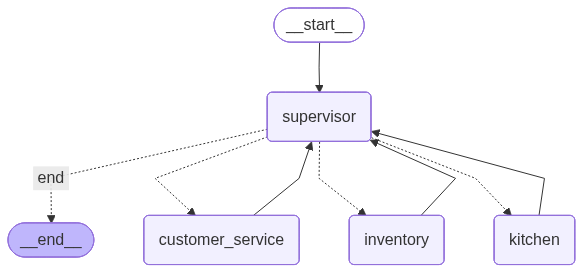

✅ Graph visualization displayed above


In [17]:
try:
    from IPython.display import Image, display
    display(Image(multi_agent_app.get_graph().draw_mermaid_png()))
    print("✅ Graph visualization displayed above")
except Exception as e:
    print(f"⚠️ Could not display graph: {e}")
    print("\nGraph structure (text):")
    print(multi_agent_app.get_graph())

## 🎯 Exercises

### Exercise 7: Add a Payment Agent

**Task**: Extend the multi-agent system with payment processing:
1. Create payment tools (process_payment, send_confirmation_email)
2. Add a payment agent to the workflow
3. Update supervisor to route payment tasks
4. Test the complete flow: customer → inventory → kitchen → payment

In [18]:
# TODO: Add payment tools
@tool
def process_payment(customer_id: str, amount: float) -> str:
    """Process payment for an order."""
    # Your implementation here
    pass

# TODO: Create payment agent
# TODO: Add to workflow
# TODO: Update supervisor routing

### Exercise 8: Handle Agent Failures

**Task**: Add error handling when agents can't complete tasks:
1. Detect when inventory is out of stock
2. Detect when the item is not in the price_list
3. Have supervisor route to customer_service for alternatives
4. Log failed attempts
5. Provide graceful degradation

In [19]:
# TODO: Enhance supervisor with error handling logic
# TODO: Add fallback routes
# TODO: Test with out-of-stock scenarios

## Summary: What We Built

### ✅ Session 2.4 Achievements:

1. **Supervisor Architecture**: Central coordinator managing specialized agents
2. **Specialized Agents**: Each with domain-specific tools
3. **Dynamic Routing**: Supervisor decides workflow based on task
4. **Tool Integration**: Real tools from previous notebooks
5. **Bidirectional Communication**: Agents report back to supervisor
6. **Realistic Workflow**: Mirrors actual business organization

### 🏗️ Architecture Pattern:

```
              [Supervisor Agent]
                      |
         _____________|______________
        |              |             |
[Customer Service] [Inventory]  [Kitchen]
        |              |             |
         \_____________|_____________/
                      |
              [Supervisor Agent]
                      |
                  [FINISH]
```

### 🤖 Agent Capabilities:

**Customer Service Agent:**
- lookup_customer: Find customer details
- track_order: Check order status

**Inventory Agent:**
- check_product_availability: Verify stock
- calculate_order_total: Pricing calculation
- update_inventory_levels: Stock management

**Kitchen Agent:**
- schedule_production: Add to production queue
- quality_check: QC validation

**Supervisor Agent:**
- Routes tasks to appropriate agents
- Coordinates multi-step workflows
- Decides when workflow is complete

### 🎉 Session 2 Complete!

You've built a production-ready multi-agent system that:
- Uses real tools and data
- Handles complex workflows
- Scales with business complexity
- Mirrors real-world organization

### 🚀 Next: Session 3 - RAG

We'll add knowledge retrieval:
- Document processing
- Semantic search
- Policy and procedure lookup
- Context-aware responses

**Excellent work completing Session 2! 🎊**